# Graph Neural Network for Multi-Asset Market Modeling — Variant C 📈

This notebook implements a GNN + LSTM model for predicting the next-step direction of Asset A using multi-asset time series, incorporating **learnable attention** over a set of precomputed correlation windows.

### Features
- Candidate correlation windows: **30min, 1h, 2h, 4h**
- **NaN-safe** normalization and correlation calculation.
- **Multi-window attention** (softmax-weighted combination) for dynamic correlation weighting.
- Monitoring attention weights per epoch for **interpretability**.
- Synthetic dataset $T \approx 3000$.

In [17]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Research-grade GNN-LSTM pipeline for multi-asset market modeling.
Predicts direction of price for Asset A using multi-window attention over correlations.

Structure:
1) Synthetic data generation (3k rows, 5m intervals)
2) Preprocessing, cleaning, winsorization, normalization
3) Rolling correlations with multiple windows (5 windows)
4) Dataset + DataLoader + collate_fn
5) GNN (GCN-style) + LSTM temporal aggregator + classifier
6) Train/Val/Test split 50-20-30
7) Training loop with accuracy, loss tracking
8) Monitoring attention + avg adjacency
9) Visualization for train and for test
"""

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import pandas as pd
from pathlib import Path

In [18]:

# ============================================================
# 1. Load data
# ============================================================


def load_asset(asset):
    freq = '5min'
    DATA_DIR = Path('../dataset')
    path = DATA_DIR / f"{asset}_{freq}.csv"

    df = pd.read_csv(path)
    df['timestamp'] = pd.to_datetime(df["system_time"])
    df['timestamp'] = df['timestamp'].dt.round('min')
    df = df.sort_values('timestamp').set_index('timestamp')
    return df[['midpoint','bids_notional_0']]  
    
df_ADA = load_asset("ADA").rename(columns={'midpoint': 'ADA', 'bids_notional_0': 'vol_ADA'})
df_BTC = load_asset("BTC").rename(columns={'midpoint': 'BTC', 'bids_notional_0': 'vol_BTC'})
df_ETH = load_asset("ETH").rename(columns={'midpoint': 'ETH', 'bids_notional_0': 'vol_ETH'})
df = df_ADA.join(df_BTC).join(df_ETH)

df.rename(columns={'ADA': 'price_A', 'vol_ADA': 'vol_A', 'BTC': 'price_B', 'vol_BTC': 'vol_B', 'ETH': 'price_C', 'vol_ETH': 'vol_C'}, inplace=True)
df.reset_index(inplace=True)

T = len(df)

# log returns & target
df["lr_A"] = np.log(df["price_A"]).diff().fillna(0)
df["lr_B"] = np.log(df["price_B"]).diff().fillna(0)
df["lr_C"] = np.log(df["price_C"]).diff().fillna(0)
df["dir_C_next"] = (df["price_C"].shift(-1) > df["price_C"]).astype(int)

# ============================================================
# 2. Full cleaning pipeline
# ============================================================

for col in ["vol_A", "vol_B", "vol_C"]:
    df[col] = df[col].clip(lower=1e-6)

def winsorize(series, q=0.995):
    low = series.quantile(1-q)
    high = series.quantile(q)
    return series.clip(lower=low, upper=high)

for col in ["vol_A", "vol_B", "vol_C"]:
    df[col] = winsorize(df[col])

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.ffill(inplace=True)
df.bfill(inplace=True)

for col in ["price_A", "price_B", "price_C"]:
    df[col] = df[col].clip(lower=1e-8)

df["lr_A"] = np.log(df["price_A"]).diff().fillna(0)
df["lr_B"] = np.log(df["price_B"]).diff().fillna(0)
df["lr_C"] = np.log(df["price_C"]).diff().fillna(0)

for col in ["lr_A", "lr_B", "lr_C"]:
    df[col] = df[col].clip(lower=-0.2, upper=0.2)

print("\nSanitized Data Summary:\n", df.describe())



Sanitized Data Summary:
            price_A         vol_A       price_B          vol_B      price_C  \
count  3367.000000   3367.000000   3367.000000    3367.000000  3367.000000   
mean      1.315086   6653.414656  59974.776253   73998.053550  2227.342008   
std       0.102222  10142.149344   2488.107862  125426.930401   154.604639   
min       1.136350      1.220000  52947.105000       1.852600  1942.845000   
25%       1.214750   2026.534973  57993.845000    1530.915039  2122.535000   
50%       1.299500   3189.639893  60152.315000    8997.179688  2167.635000   
75%       1.415900   5507.334961  62188.030000   96491.503906  2378.455000   
max       1.557050  77046.272500  64760.235000  747358.843750  2544.995000   

               vol_C         lr_A         lr_B         lr_C   dir_C_next  
count    3367.000000  3367.000000  3367.000000  3367.000000  3367.000000  
mean    27627.924077     0.000024     0.000006     0.000039     0.509356  
std     52078.203930     0.004807     0.002455

In [19]:

# ============================================================
# 3. Multi-window correlations
# ============================================================

candidate_windows = [6, 12, 24, 48, 96]   # 30m, 1h, 2h, 4h, 8h
n_w = len(candidate_windows)

edges = [("A","B"), ("A","C"), ("C","B")]
n_edges = len(edges)

corr_array = np.zeros((T, n_edges, n_w), dtype=np.float32)

for wi, w in enumerate(candidate_windows):
    r_ab = df["lr_A"].rolling(w, min_periods=1).corr(df["lr_B"])
    r_ac = df["lr_A"].rolling(w, min_periods=1).corr(df["lr_C"])
    r_cb = df["lr_C"].rolling(w, min_periods=1).corr(df["lr_B"])

    corr_array[:,0,wi] = np.nan_to_num(r_ab)
    corr_array[:,1,wi] = np.nan_to_num(r_ac)
    corr_array[:,2,wi] = np.nan_to_num(r_cb)

print("corr_array shape:", corr_array.shape)


corr_array shape: (3367, 3, 5)


In [20]:

# ============================================================
# 4. Dataset + DataLoader
# ============================================================

class MarketDataset(Dataset):
    def __init__(self, df, corr_array, window=12, normalize=True):
        self.df = df.reset_index(drop=True)
        self.T = len(df)
        self.window = window
        self.corr_array = corr_array
        self.normalize = normalize

        prices = df[["price_A","price_B","price_C"]].values
        lv = np.log1p(df[["vol_A","vol_B","vol_C"]].values)

        self.p_mean = prices.mean(0)
        self.p_std  = prices.std(0) + 1e-6
        self.v_mean = lv.mean(0)
        self.v_std  = lv.std(0) + 1e-6

    def __len__(self):
        return self.T - self.window - 1

    def __getitem__(self, idx):
        x_seq = []
        for t in range(idx, idx+self.window):
            row = self.df.loc[t]

            price = np.array([row.price_A, row.price_B, row.price_C], np.float32)
            vol   = np.log1p(np.array([row.vol_A, row.vol_B, row.vol_C], np.float32))

            if self.normalize:
                price = (price - self.p_mean)/self.p_std
                vol   = (vol   - self.v_mean)/self.v_std

            nf = np.stack([price, vol], axis=1).astype(np.float32)
            x_seq.append(torch.tensor(nf))

        target = int(self.df.loc[idx+self.window].dir_C_next)

        corr_slice = self.corr_array[idx:idx+self.window,:,:]

        return x_seq, torch.tensor(target, dtype=torch.long), torch.tensor(corr_slice, dtype=torch.float32)

def collate_fn(batch):
    return batch[0]


In [21]:

# ============================================================
# 5. Train/Val/Test split 50–20–30
# ============================================================

total_len = len(df)
train_end = int(total_len * 0.50)
val_end   = int(total_len * 0.70)

df_train = df.iloc[:train_end].reset_index(drop=True)
df_val   = df.iloc[train_end:val_end].reset_index(drop=True)
df_test  = df.iloc[val_end:].reset_index(drop=True)

corr_train = corr_array[:train_end]
corr_val   = corr_array[train_end:val_end]
corr_test  = corr_array[val_end:]

dataset_train = MarketDataset(df_train, corr_train)
dataset_val   = MarketDataset(df_val,   corr_val)
dataset_test  = MarketDataset(df_test,  corr_test)

loader_train = DataLoader(dataset_train, batch_size=1, shuffle=True, collate_fn=collate_fn)
loader_val   = DataLoader(dataset_val,   batch_size=1, shuffle=False, collate_fn=collate_fn)
loader_test  = DataLoader(dataset_test,  batch_size=1, shuffle=False, collate_fn=collate_fn)

print("\nDataset sizes:")
print("Train:", len(dataset_train))
print("Val:  ", len(dataset_val))
print("Test: ", len(dataset_test))



Dataset sizes:
Train: 1670
Val:   660
Test:  998


## 6. GNN + LSTM model

In [22]:

# ============================================================
# 6. GNN + LSTM model
# ============================================================

class GNN_LSTM(nn.Module):
    def __init__(self, hidden_dim=32, lstm_hidden=32, n_edges=3, n_windows=5):
        super().__init__()
        self.fc_node = nn.Linear(2, hidden_dim)
        self.attn = nn.Parameter(torch.randn(n_edges, n_windows))
        self.lstm = nn.LSTM(hidden_dim, lstm_hidden, batch_first=True)
        self.fc_out = nn.Linear(lstm_hidden, 2)

    def forward(self, x_seq, corr_slice):
        L = len(x_seq)
        x = torch.stack([self.fc_node(e) for e in x_seq], dim=0)  # (L,3,h)

        attn_w = F.softmax(self.attn, dim=-1)  # (3,5)
        corr_w = torch.einsum("l e w, e w -> l e", corr_slice, attn_w)

        h = x.clone()

        # message passing (GCN-style)
        h[:,0,:] += corr_w[:,0:1]*x[:,1,:] + corr_w[:,1:2]*x[:,2,:]
        h[:,1,:] += corr_w[:,0:1]*x[:,0,:] + corr_w[:,2:3]*x[:,2,:]
        h[:,2,:] += corr_w[:,1:2]*x[:,0,:] + corr_w[:,2:3]*x[:,1,:]

        # only node A -> LSTM
        a_seq = h[:,0,:].unsqueeze(0)  # (1,L,hid)
        out,_ = self.lstm(a_seq)
        last = out[:, -1, :]  # final hidden state
        logits = self.fc_out(last)
        return logits, attn_w, corr_w

model = GNN_LSTM()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


## 7. Training loop (Train + Val)

In [23]:

# ============================================================
# 7. Training loop (Train + Val)
# ============================================================

n_epochs = 15
train_loss_hist = []
train_acc_hist = []
val_acc_hist = []
attn_history = []
avg_adj_hist = []

def evaluate(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x_seq, target, corr_slice in loader:
            logits, _, _ = model(x_seq, corr_slice)
            pred = logits.argmax(1)
            correct += (pred == target).sum().item()
            total += 1
    return correct/total if total>0 else 0

for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    attn_epoch = []
    adj_epoch = []

    for x_seq, target, corr_slice in loader_train:
        optimizer.zero_grad()
        logits, attn_w, corr_w = model(x_seq, corr_slice)
        loss = criterion(logits, target.unsqueeze(0))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = logits.argmax(1)
        correct += (pred == target).sum().item()
        total += 1

        attn_epoch.append(attn_w.detach().numpy())
        adj_epoch.append(corr_w.mean(0).detach().numpy())

    train_loss_hist.append(total_loss/total)
    train_acc_hist.append(correct/total)
    val_acc = evaluate(loader_val)
    val_acc_hist.append(val_acc)

    attn_history.append(np.mean(attn_epoch, axis=0))
    avg_adj_hist.append(np.mean(adj_epoch, axis=0))

    best_window = candidate_windows[np.argmax(attn_history[-1].mean(0))]

    print(f"Epoch {epoch+1}/{n_epochs} | "
          f"TrainLoss={train_loss_hist[-1]:.4f} | "
          f"TrainAcc={train_acc_hist[-1]:.4f} | "
          f"ValAcc={val_acc:.4f} | "
          f"BestWindow={best_window}")

attn_history = np.stack(attn_history)
avg_adj_hist = np.stack(avg_adj_hist)


Epoch 1/15 | TrainLoss=0.6982 | TrainAcc=0.4988 | ValAcc=0.5394 | BestWindow=6
Epoch 2/15 | TrainLoss=0.6939 | TrainAcc=0.5024 | ValAcc=0.5303 | BestWindow=6
Epoch 3/15 | TrainLoss=0.6935 | TrainAcc=0.5156 | ValAcc=0.5167 | BestWindow=6
Epoch 4/15 | TrainLoss=0.6933 | TrainAcc=0.5144 | ValAcc=0.5273 | BestWindow=6
Epoch 5/15 | TrainLoss=0.6930 | TrainAcc=0.5150 | ValAcc=0.5530 | BestWindow=6
Epoch 6/15 | TrainLoss=0.6920 | TrainAcc=0.5335 | ValAcc=0.5288 | BestWindow=6
Epoch 7/15 | TrainLoss=0.6914 | TrainAcc=0.5263 | ValAcc=0.5424 | BestWindow=6
Epoch 8/15 | TrainLoss=0.6894 | TrainAcc=0.5491 | ValAcc=0.5333 | BestWindow=6
Epoch 9/15 | TrainLoss=0.6888 | TrainAcc=0.5365 | ValAcc=0.5182 | BestWindow=6
Epoch 10/15 | TrainLoss=0.6858 | TrainAcc=0.5533 | ValAcc=0.5212 | BestWindow=6
Epoch 11/15 | TrainLoss=0.6834 | TrainAcc=0.5551 | ValAcc=0.5136 | BestWindow=6
Epoch 12/15 | TrainLoss=0.6791 | TrainAcc=0.5635 | ValAcc=0.5045 | BestWindow=6
Epoch 13/15 | TrainLoss=0.6776 | TrainAcc=0.5659 

## 8. Test evaluation

In [24]:

# ============================================================
# 8. Test evaluation
# ============================================================

test_acc = evaluate(loader_test)
print("\n==========================")
print("FINAL TEST ACCURACY:", test_acc)
print("==========================\n")



FINAL TEST ACCURACY: 0.5080160320641283



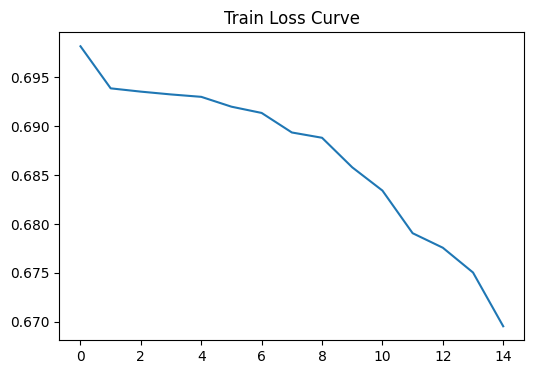

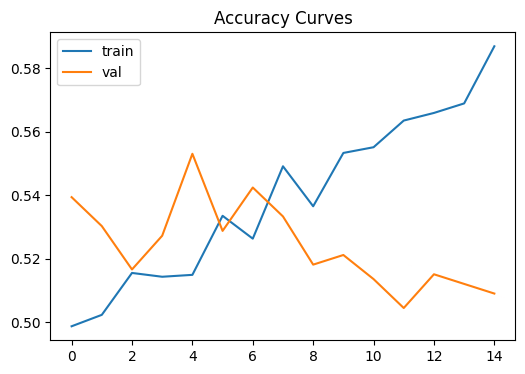

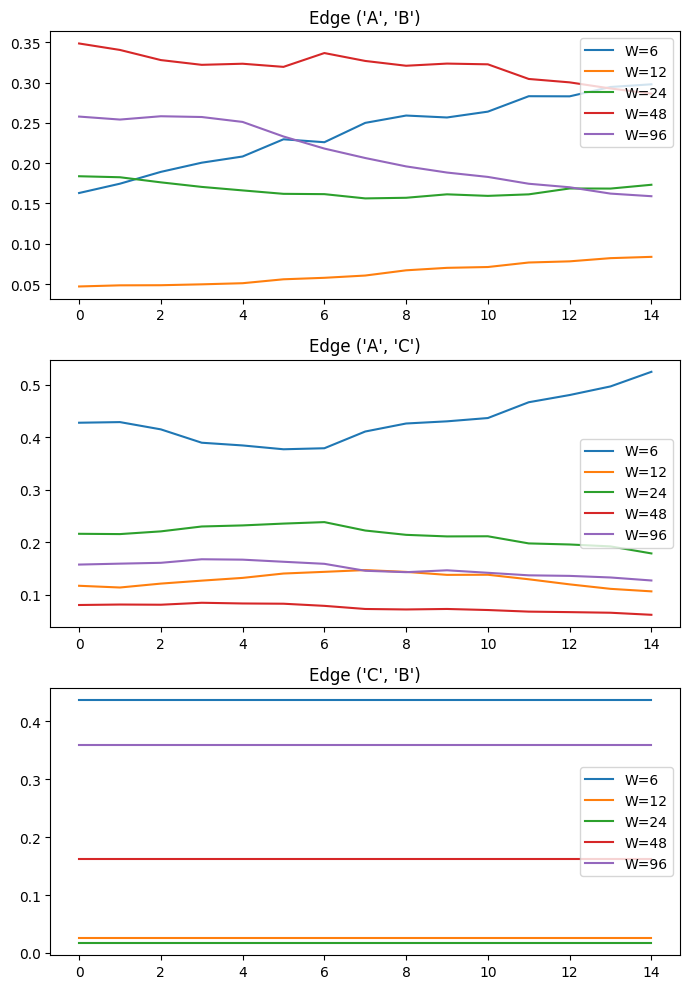

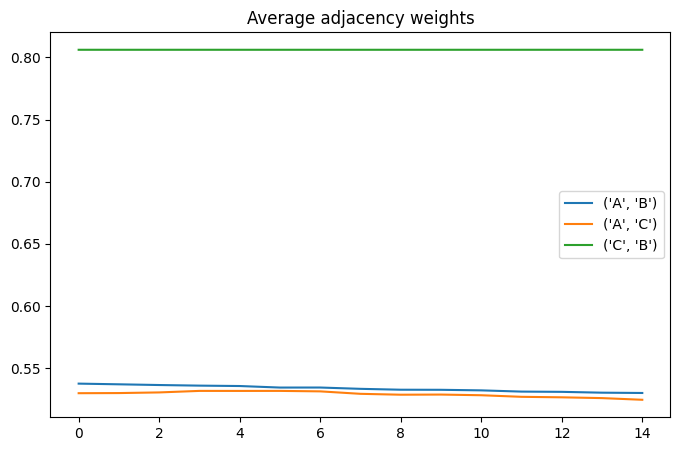

Done.


In [25]:

# ============================================================
# 9. Visualization
# ============================================================

plt.figure(figsize=(6,4))
plt.plot(train_loss_hist)
plt.title("Train Loss Curve")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(train_acc_hist, label="train")
plt.plot(val_acc_hist, label="val")
plt.title("Accuracy Curves")
plt.legend()
plt.show()

# Attention evolution
fig, axes = plt.subplots(n_edges,1, figsize=(7,10))
for e in range(n_edges):
    for w in range(n_w):
        axes[e].plot(attn_history[:,e,w], label=f"W={candidate_windows[w]}")
    axes[e].set_title(f"Edge {edges[e]}")
    axes[e].legend()
plt.tight_layout()
plt.show()

# Average adjacency
plt.figure(figsize=(8,5))
for e in range(n_edges):
    plt.plot(avg_adj_hist[:,e], label=str(edges[e]))
plt.legend()
plt.title("Average adjacency weights")
plt.show()

print("Done.")
